# Only Parallel Concatenation in the model,no skip connections batch size:10 , LR: 0.0008 EPOCHS:30

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, Flatten, Dense, BatchNormalization,Dropout,GlobalAveragePooling2D,Concatenate,Input,Add
from tensorflow.keras.activations import relu, softmax,elu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import zipfile
from sklearn.metrics import precision_score, recall_score
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical# used for categorical hot coding

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
np.random.seed(60)
tf.random.set_seed(60)

In [ ]:
#@title Data Path

AN_csv11 = '/content/drive/MyDrive/MESSIDOR/Base11/Annotation_Base11.xls'
an_11= pd.read_excel(AN_csv11, usecols=['Image name', 'Risk of macular edema '])

AN_csv12 = '/content/drive/MyDrive/MESSIDOR/Base12/Annotation Base12.xls'
an_12= pd.read_excel(AN_csv12, usecols=['Image name', 'Risk of macular edema '])

AN_csv13 = '/content/drive/MyDrive/MESSIDOR/Base13/Annotation_Base13.xls'
an_13= pd.read_excel(AN_csv13, usecols=['Image name', 'Risk of macular edema '])

AN_csv14 = '/content/drive/MyDrive/MESSIDOR/Base14/Annotation Base14.xls'
an_14= pd.read_excel(AN_csv14, usecols=['Image name', 'Risk of macular edema '])

AN_csv21 = '/content/drive/MyDrive/MESSIDOR/Base21/Annotation Base21.xls'
an_21= pd.read_excel(AN_csv21, usecols=['Image name', 'Risk of macular edema '])

AN_csv22 = '/content/drive/MyDrive/MESSIDOR/Base22/Annotation Base22.xls'
an_22= pd.read_excel(AN_csv22, usecols=['Image name', 'Risk of macular edema '])

AN_csv23 = '/content/drive/MyDrive/MESSIDOR/Base23/Annotation Base23.xls'
an_23= pd.read_excel(AN_csv23, usecols=['Image name', 'Risk of macular edema '])

AN_csv24 = '/content/drive/MyDrive/MESSIDOR/Base24/Annotation Base24.xls'
an_24= pd.read_excel(AN_csv24, usecols=['Image name', 'Risk of macular edema '])

AN_csv31 = '/content/drive/MyDrive/MESSIDOR/Base31/Annotation Base31.xls'
an_31= pd.read_excel(AN_csv31, usecols=['Image name', 'Risk of macular edema '])

AN_csv32 = '/content/drive/MyDrive/MESSIDOR/Base32/Annotation Base32.xls'
an_32= pd.read_excel(AN_csv32, usecols=['Image name', 'Risk of macular edema '])

AN_csv33 = '/content/drive/MyDrive/MESSIDOR/Base33/Annotation Base33.xls'
an_33= pd.read_excel(AN_csv33, usecols=['Image name', 'Risk of macular edema '])

AN_csv34 = '/content/drive/MyDrive/MESSIDOR/Base34/Annotation Base34.xlsx'
an_34= pd.read_excel(AN_csv34, usecols=['Image name', 'Risk of macular edema '])


data_path11 ="/content/drive/MyDrive/MESSIDOR/Base11"
data_path12= "/content/drive/MyDrive/MESSIDOR/Base12"
data_path13= "/content/drive/MyDrive/MESSIDOR/Base13"
data_path14= "/content/drive/MyDrive/MESSIDOR/Base14"
data_path21= "/content/drive/MyDrive/MESSIDOR/Base21"
data_path22= "/content/drive/MyDrive/MESSIDOR/Base22"
data_path23= "/content/drive/MyDrive/MESSIDOR/Base23"
data_path24= "/content/drive/MyDrive/MESSIDOR/Base24"
data_path31= "/content/drive/MyDrive/MESSIDOR/Base31"
data_path32= "/content/drive/MyDrive/MESSIDOR/Base32"
data_path33= "/content/drive/MyDrive/MESSIDOR/Base33"
data_path34= "/content/drive/MyDrive/MESSIDOR/Base34"

train_csv_path ='/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_csv_path ='/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

#Read train and test CSV files with specific columns
train_df = pd.read_csv(train_csv_path, usecols=['Image name', 'Risk of macular edema '])
test_df = pd.read_csv(test_csv_path, usecols=['Image name', 'Risk of macular edema '])

# Convert 'Risk of macular edema' column to string type
train_df['Risk of macular edema '] = train_df['Risk of macular edema '].astype(str)
test_df['Risk of macular edema '] = test_df['Risk of macular edema '].astype(str)

train_df['Image name'] = train_df['Image name'].astype(str)+ '.jpg'
test_df['Image name'] = test_df['Image name'].astype(str)+ '.jpg'

#Load image from the dataset
train_data_dir= '/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/1. Original Images/a. Training Set'
test_data_dir = '/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/1. Original Images/b. Testing Set'


In [ ]:
#@title Image Read Function

#define function to read images and labels messidor dataset
def read_images_and_labels(data_path, annotation_df):
    data = []
    for index, row in annotation_df.iterrows():
        image_name = row['Image name']
        label = row['Risk of macular edema ']
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path)  # assuming in open cv compatible format
        image = cv2.resize(image, (224, 224))
        data.append([image, label])
    return data

In [ ]:
#@title calling read image functions

#read images and labels for each dataset

data1 = read_images_and_labels(data_path11, an_11)
data2 = read_images_and_labels(data_path12, an_12)
data3 = read_images_and_labels(data_path13, an_13)
data4 = read_images_and_labels(data_path14, an_14)
data5 = read_images_and_labels(data_path21, an_21)
data6 = read_images_and_labels(data_path22, an_22)
data7 = read_images_and_labels(data_path23, an_23)
data8 = read_images_and_labels(data_path24, an_24)
data9 = read_images_and_labels(data_path31, an_31)
data10 = read_images_and_labels(data_path32, an_32)
data11 = read_images_and_labels(data_path33, an_33)
data12 = read_images_and_labels(data_path34, an_34)
#data13 = read_images_and_labels(train_data_dir, train_df)
#data14 = read_images_and_labels(test_data_dir, test_df)
data= data1+ data2+ data3+ data4 + data5 + data6 + data7 +data8 + data9 + data10 + data11 + data12

print("data reading done")

data reading done


In [ ]:
np.random.shuffle(data)

In [ ]:
X= []
y=[]

for features, label in data:
  X.append(features)
  y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

# y= to_categorical(y, num_classes =3)

# Stratified splitting for train-test split
n_splits = 1
test_size = 0.2
stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=43)

In [ ]:
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Further split training data into training and validation sets
for train_index, val_index in stratified_split.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]

In [ ]:
# Check classwise distribution in train, test, and validation sets
unique_classes = np.unique(np.concatenate((y_train, y_test, y_val)))
for class_label in unique_classes:
    print(f"Class {class_label}:")
    print(f"Train: {np.sum(y_train == class_label)} images")
    print(f"Test: {np.sum(y_test == class_label)} images")
    print(f"Validation: {np.sum(y_val == class_label)} images")
    print('.........')

Class 0:
Train: 623 images
Test: 195 images
Validation: 156 images
.........
Class 1:
Train: 48 images
Test: 15 images
Validation: 12 images
.........
Class 2:
Train: 97 images
Test: 30 images
Validation: 24 images
.........


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, Flatten, Dense, BatchNormalization,Dropout,GlobalAveragePooling2D,Concatenate,Input,Add

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train, num_classes=3)
val_labels = to_categorical(y_val, num_classes=3)
test_labels_one_hot = to_categorical(y_test, num_classes=3)

In [ ]:
# CREATING THE CNN MODEL:

input_layer=Input(shape=(224, 224, 3))

# BLOCK 1
x=Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu',)(input_layer)
x=BatchNormalization()(x)
x=MaxPooling2D((2, 2))(x)
x1=Conv2D(4, (7, 7), strides=(2, 2),padding='same',activation='relu',)(input_layer)
x1=Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu')(x1)
concatenated = Concatenate()([x1, x])

# BLOCK 2
x=(Conv2D(48, (3, 3), strides=(1, 1), padding='same', activation='relu'))(concatenated)
x=(BatchNormalization())(x)
x=(MaxPooling2D((2, 2)))(x)

# BLOCK 3
block3_output = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
block3_output= BatchNormalization()(block3_output)
block3_output = MaxPooling2D((2, 2))(block3_output)

# BLOCK 4
block4_output = Conv2D(80, (3, 3), strides=(1, 1), padding='same', activation='relu')(block3_output)
block4_output = BatchNormalization()(block4_output)
block4_output = Conv2D(40, (1, 1), strides=(1, 1), padding='same', activation='relu')(block4_output)
block4_output = Conv2D(80, (3, 3), strides=(1, 1), padding='same', activation='relu')(block4_output)
block4_output = BatchNormalization()(block4_output)

#Parallel Branch
#z= Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(block3_output)
#z=BatchNormalization()(z)
#z= Conv2D(40, (1, 1), strides=(1, 1), padding='same', activation='relu')(block3_output)
#z=BatchNormalization()(z)

# Concatenate Block 3 and Block 4 outputs
#concatenated = Concatenate()([block3_output, block4_output])
x1= MaxPooling2D((2, 2))(block4_output)# skip connection to input of block 6, change to x1, add

# BLOCK 5
x = Conv2D(96, (3, 3), strides=(1, 1), padding='same', activation='relu')(x1)
x = BatchNormalization()(x)
x = Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)# try 3,3 filter size, gap with block5, try concatenate, 32 filters try,dilation rate
x = Conv2D(96, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# DEPTH WISE CONV BLOCK 1
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

    #BLOCK 6
x2=MaxPooling2D((2, 2))(x)
#concatenatedd = Concatenate()([x2, x])

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x2)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
    #BLOCK 7
   #Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu'),
  # BatchNormalization(),#- ADDED THIS AS WELL
    #DEPTH WISE CONV LAYER
    #DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu'),
    #Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
    #Layer 8
    #Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    #BatchNormalization(),
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)#--- ADDED THIS
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
#x = Dense(128,activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 4)          592       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                               

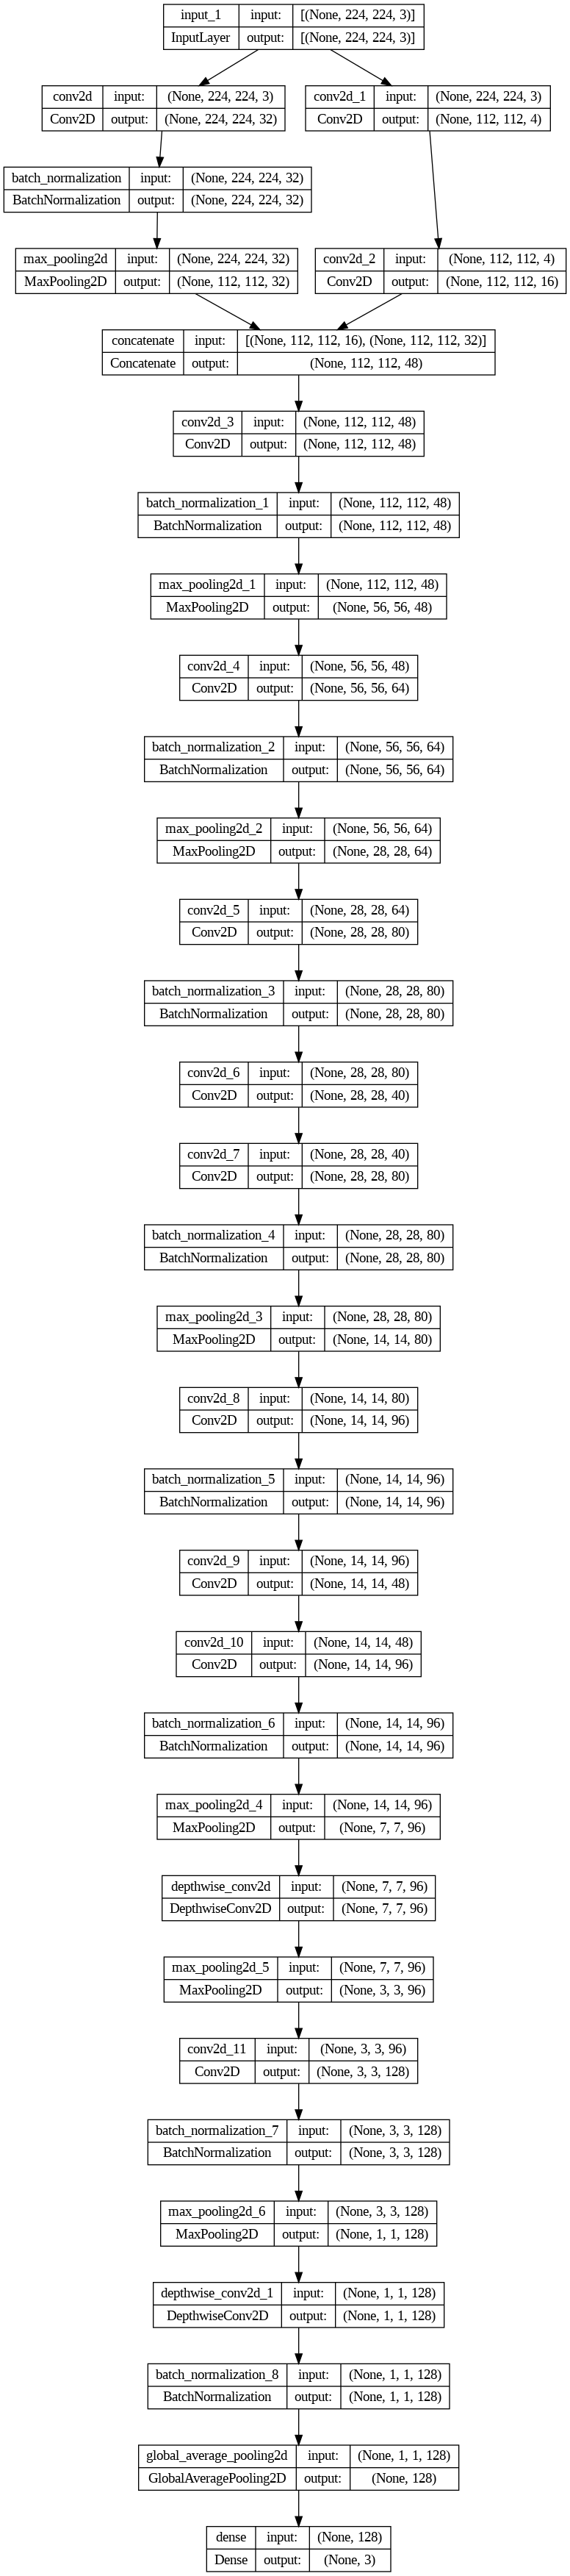

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model (model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
# Compile the model
# Define initial learning rate
# Compile the model (assuming 'model' is already defined as per your previous code)
initial_learning_rate = 0.0008
custom_optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

def lr_schedule(epoch, lr):
    if epoch < 10:
        return initial_learning_rate
    else:
        return lr * 0.96

lr_scheduler = LearningRateScheduler(lr_schedule)
# Define LearningRateScheduler callback

# Define ReduceLROnPlateau callback
#reduce_lr = ReduceLROnPlateau(
#   monitor='val_loss',   # Metric to monitor
#    factor=0.96,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
#    patience=10,           # Number of epochs with no improvement after which learning rate will be reduced
#    min_lr=0.00001         # Lower bound on the learning rate

In [ ]:
history = model.fit(X_train, train_labels, epochs=30, batch_size=10, validation_data=(X_val, val_labels),callbacks=[lr_scheduler])

Epoch 1/30
77/77 [==============================] - 18s 62ms/step - loss: 0.9065 - accuracy: 0.6133 - val_loss: 0.6887 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 2/30
77/77 [==============================] - 2s 31ms/step - loss: 0.5998 - accuracy: 0.8060 - val_loss: 0.6040 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 3/30
77/77 [==============================] - 2s 28ms/step - loss: 0.5650 - accuracy: 0.8073 - val_loss: 0.6030 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 4/30
77/77 [==============================] - 2s 28ms/step - loss: 0.5750 - accuracy: 0.8060 - val_loss: 0.5977 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 5/30
77/77 [==============================] - 2s 27ms/step - loss: 0.5473 - accuracy: 0.8099 - val_loss: 0.6054 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 6/30
77/77 [==============================] - 2s 30ms/step - loss: 0.5532 - accuracy: 0.8138 - val_loss: 0.5748 - val_accuracy: 0.8125 - lr: 8.0000e-04
Epoch 7/30
77/77 [==============================] -

In [ ]:
# Evaluate the model on testing set
test_loss, test_acc = model.evaluate(X_test, test_labels_one_hot)
print('Testing accuracy:', test_acc)


8/8 [==============================] - 2s 119ms/step - loss: 0.8199 - accuracy: 0.8292
Testing accuracy: 0.8291666507720947


In [ ]:
# Calculate precision and recall on training set
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_precision = precision_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
train_recall = recall_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

24/24 [==============================] - 1s 19ms/step
Training Precision: 0.9558960074280408
Training Recall: 0.5156786941580757


In [ ]:
# Calculate precision and recall on testing set
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_precision = precision_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
test_recall = recall_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

8/8 [==============================] - 0s 17ms/step
Testing Precision: 0.5553171196948021
Testing Recall: 0.3871794871794872


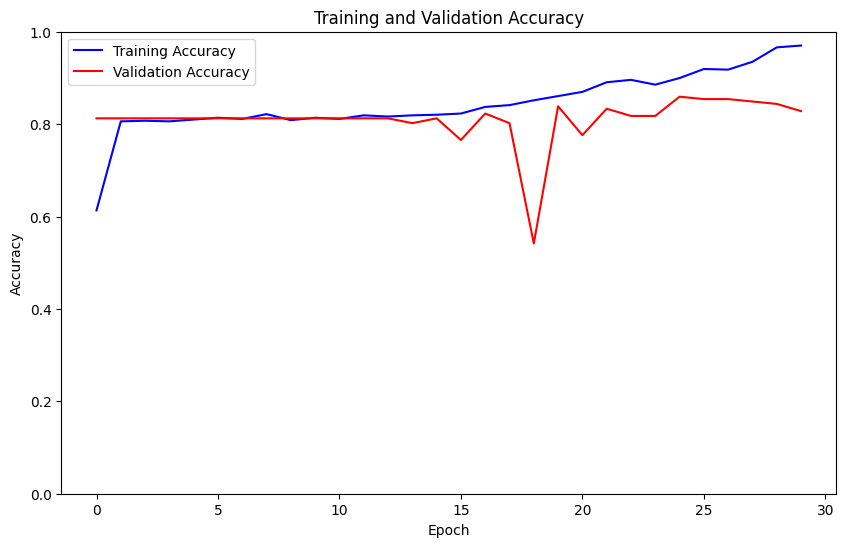

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

8/8 [==============================] - 0s 20ms/step - loss: 0.8199 - accuracy: 0.8292
Testing accuracy: 0.8291666507720947
24/24 [==============================] - 0s 20ms/step
Training Precision: 0.9558960074280408
Training Recall: 0.5156786941580757
8/8 [==============================] - 0s 18ms/step
Testing Precision: 0.5553171196948021
Testing Recall: 0.3871794871794872


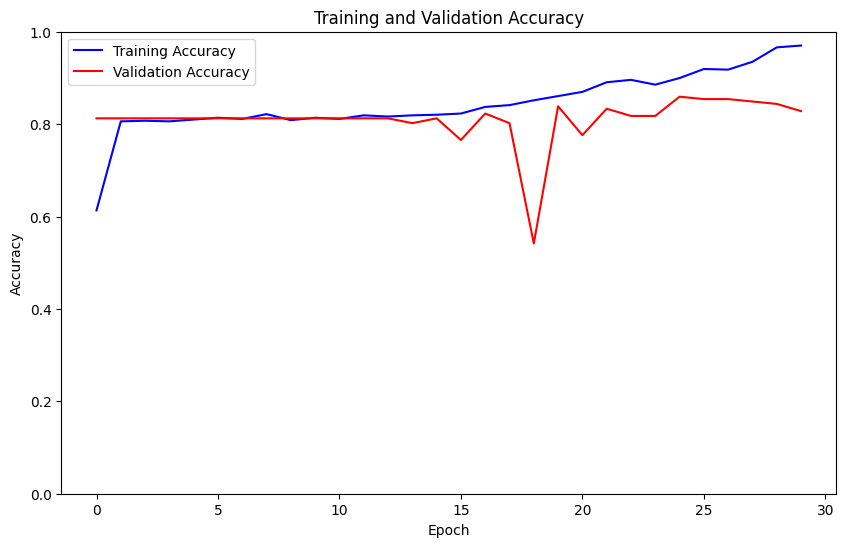

8/8 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

       DME 0       0.83      0.99      0.91       195
       DME 1       0.00      0.00      0.00        15
       DME 2       0.83      0.17      0.28        30

    accuracy                           0.83       240
   macro avg       0.56      0.39      0.39       240
weighted avg       0.78      0.83      0.77       240



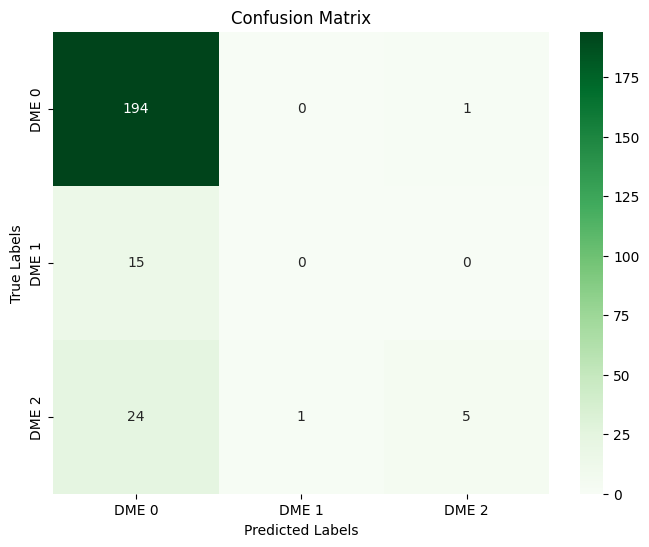

24/24 [==============================] - 0s 18ms/step


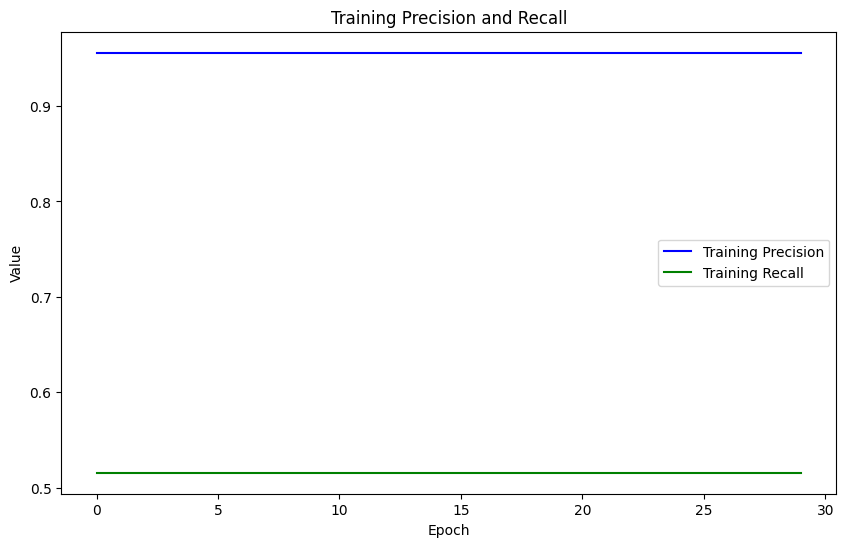

Model training took 2 seconds, 1 milliseconds
Loss values: [0.9065443873405457, 0.5997997522354126, 0.564984917640686, 0.5749775171279907, 0.5472729802131653, 0.5531737804412842, 0.5525553822517395, 0.5333468914031982, 0.5533290505409241, 0.5427869558334351, 0.5394198298454285, 0.5115923881530762, 0.5305802822113037, 0.5090122818946838, 0.5093250274658203, 0.4967358112335205, 0.45507514476776123, 0.4385818541049957, 0.43469515442848206, 0.41753089427948, 0.38808485865592957, 0.3426807224750519, 0.32105839252471924, 0.33297696709632874, 0.28096649050712585, 0.23048199713230133, 0.21153564751148224, 0.17486925423145294, 0.13129998743534088, 0.11216863244771957]
Validation Loss values: [0.6887224316596985, 0.6040262579917908, 0.6029974818229675, 0.5976816415786743, 0.6054169535636902, 0.5748041272163391, 0.5890262126922607, 0.6484578251838684, 0.6541993021965027, 0.5769115686416626, 0.6959758400917053, 0.5827942490577698, 0.622150182723999, 0.5646948218345642, 0.5712825059890747, 0.598477

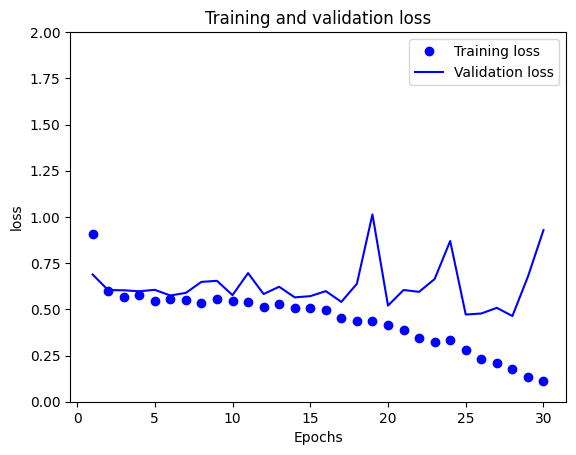

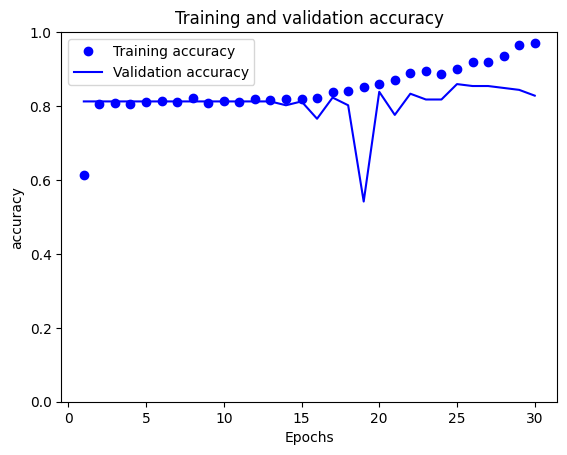

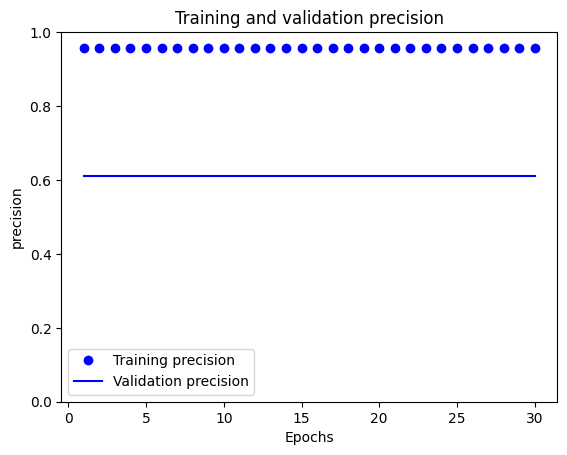

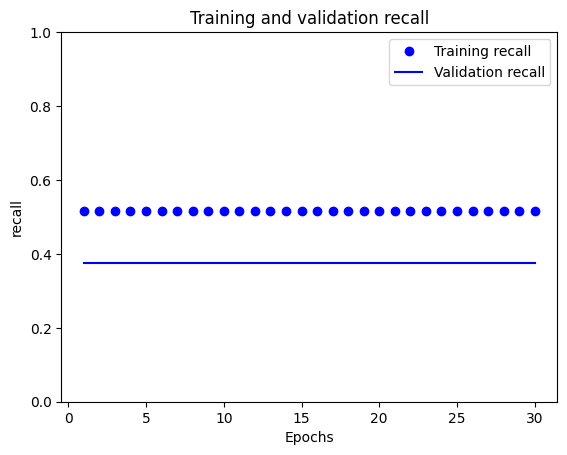

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import time

# Assume model, X_test, test_labels_one_hot, X_val, val_labels, X_train, train_labels, etc., are already defined

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, test_labels_one_hot)
print('Testing accuracy:', test_acc)

# Calculate precision and recall on the training set
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_precision = precision_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
train_recall = recall_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_precision = precision_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
test_recall = recall_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.legend()
plt.show()

# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ['DME 0', 'DME 1', 'DME 2']
report = classification_report(np.argmax(test_labels_one_hot, axis=1), y_pred_classes, target_names=class_names)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall for validation data after each epoch
history.history['val_precision'] = []
history.history['val_recall'] = []

for epoch in range(30):
    val_predictions = model.predict(X_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    val_precision = precision_score(np.argmax(val_labels, axis=1), val_predictions, average='macro')
    val_recall = recall_score(np.argmax(val_labels, axis=1), val_predictions, average='macro')
    history.history['val_precision'].append(val_precision)
    history.history['val_recall'].append(val_recall)

# Manually calculate precision and recall after each epoch
history.history['precision'] = []
history.history['recall'] = []

for epoch in range(30):
    train_predictions = model.predict(X_train)
    train_predictions = np.argmax(train_predictions, axis=1)
    train_precision = precision_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
    train_recall = recall_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
    history.history['precision'].append(train_precision)
    history.history['recall'].append(train_recall)

# Plot training precision and recall
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Training Precision', color='blue')
plt.plot(history.history['recall'], label='Training Recall', color='green')
plt.title('Training Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Measure execution time
start_time = time.time()

# Simulate a task by adding a sleep duration
time.sleep(2)  # Replace this with your actual task

end_time = time.time()
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

# Function to plot metrics
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    for metric_name in metric_name_list:
        if metric_name in hist.history:
            metric = hist.history[metric_name]
            v_metric_name = "val_" + metric_name
            v_metric = hist.history[v_metric_name] if v_metric_name in hist.history else []
            epochs = range(1, len(metric) + 1)

            plt.figure()
            plt.plot(epochs, metric, 'bo', label=f'Training {metric_name}')
            if v_metric:
                plt.plot(epochs, v_metric, 'b', label=f'Validation {metric_name}')

            max_loss = max(max(metric), max(v_metric)) if v_metric else max(metric)
            min_loss = min(min(metric), min(v_metric)) if v_metric else min(metric)
            y_max = math.ceil(max_loss)

            if min_loss > 0 or max_loss > 1:
                y_min = math.floor(min_loss)
                plt.ylim(y_min, y_max)

            plt.title(f'Training and validation {metric_name}')
            plt.xlabel('Epochs')
            plt.ylabel(metric_name)
            plt.legend()
            plt.show()

# Define the metric names
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]

# Print the values of the metrics
for metric_name in metric_names:
    if metric_name in history.history:
        print(f"{metric_name.capitalize()} values: {history.history[metric_name]}")
    if f"val_{metric_name}" in history.history:
        print(f"Validation {metric_name.capitalize()} values: {history.history[f'val_{metric_name}']}")

# Plot the metrics
plot_metrics(history, metric_names)

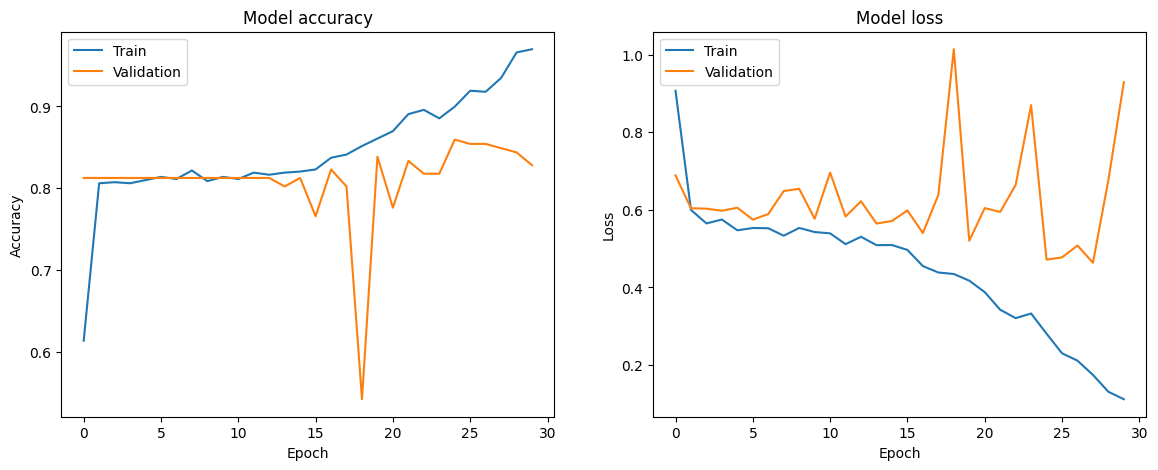

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

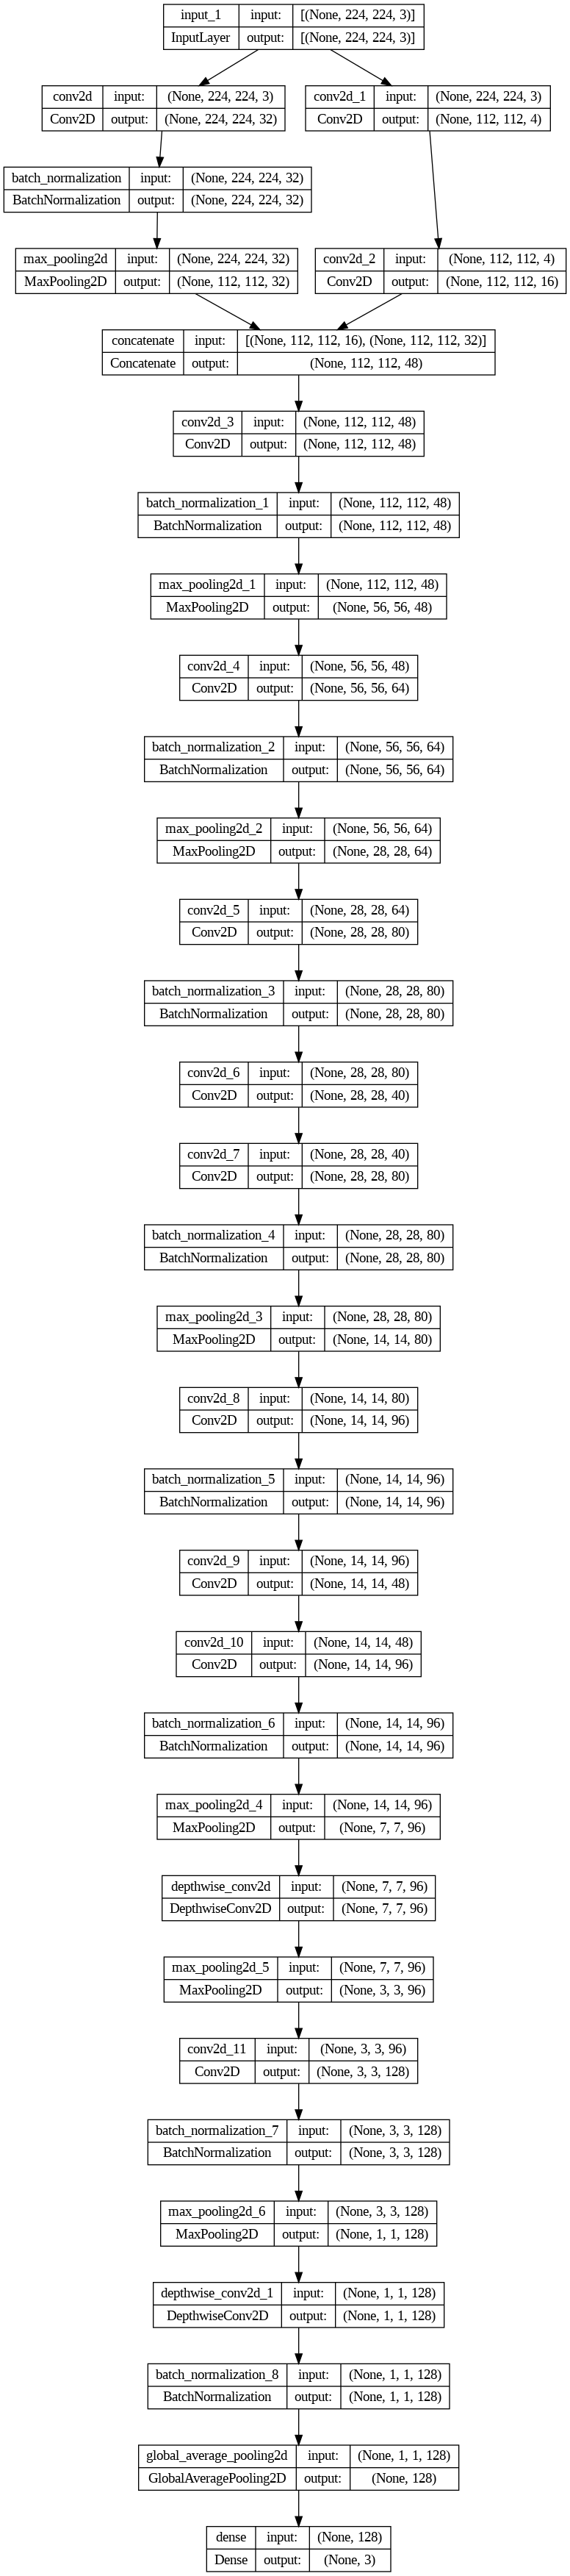

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Save the model architecture diagram to a file
plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)

# Display the saved image in Jupyter Notebook
Image(filename='convnet.png')